In [12]:
# !pip install --upgrade pyannote.audio

In [13]:
from pyannote.audio import Pipeline

In [14]:
# !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).

In [17]:
diarization_pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-3.1', use_auth_token=True)

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [18]:
from pyannote.audio.pipelines.utils.hook import ProgressHook

In [19]:
with ProgressHook() as hook:
  diarization = diarization_pipeline('interview.ogg', hook=hook)

Output()

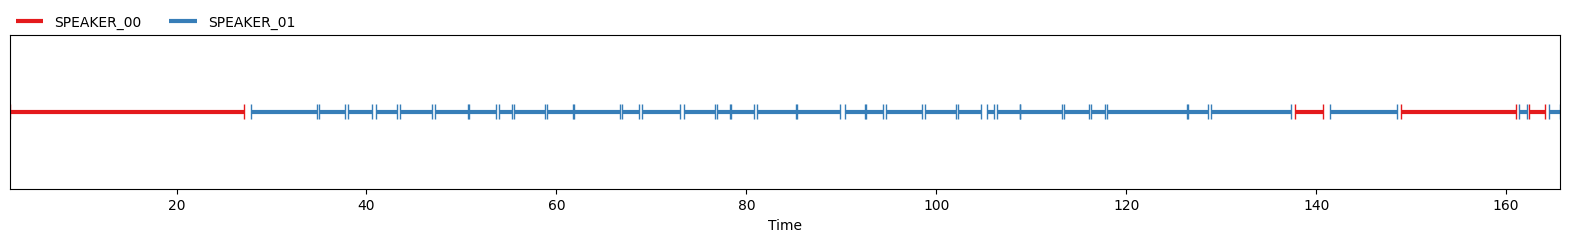

In [20]:
diarization

In [22]:
# for turn, _, speaker in diarization.itertracks(yield_label=True):
#   print(turn.start)
#   print(turn.end)
#   print(speaker)
#   print('\n\n\n')

2.46096875
27.098468750000002
SPEAKER_00




27.85784375
34.82721875
SPEAKER_01




35.04659375
37.72971875
SPEAKER_01




38.05034375
40.58159375
SPEAKER_01




40.969718750000006
43.23096875
SPEAKER_01




43.48409375
46.892843750000004
SPEAKER_01




47.196593750000005
50.672843750000006
SPEAKER_01




50.790968750000005
53.65971875
SPEAKER_01




53.946593750000005
55.330343750000004
SPEAKER_01




55.515968750000006
58.82346875
SPEAKER_01




59.009093750000005
61.69221875
SPEAKER_01




61.89471875
66.73784375000001
SPEAKER_01




66.94034375000001
68.71221875
SPEAKER_01




69.01596875
72.98159375
SPEAKER_01




73.42034375
76.67721875000001
SPEAKER_01




76.93034375
78.26346875
SPEAKER_01




78.43221875
80.81159375
SPEAKER_01




81.09846875000001
85.23284375
SPEAKER_01




85.36784375
89.85659375
SPEAKER_01




90.37971875000001
92.53971875
SPEAKER_01




92.60721875
94.42971875
SPEAKER_01




94.69971875
98.53034375
SPEAKER_01




98.78346875000001
102.04034375
SPEAKER_01



In [26]:
def consolidate_speaker_segments(diarization):
  consolidated_segments = []
  current_speaker = None
  segment_start = None

  for turn, _, speaker in diarization.itertracks(yield_label=True):
    if speaker != current_speaker:
      if current_speaker is not None:
        consolidated_segments.append((current_speaker, segment_start, turn.start))
      current_speaker = speaker
      segment_start = turn.start
    segment_end = turn.end
  if current_speaker is not None:
    consolidated_segments.append((current_speaker, segment_start, segment_end))

  return consolidated_segments

In [27]:
segments = consolidate_speaker_segments(diarization)

In [28]:
segments

[('SPEAKER_00', 2.46096875, 27.85784375),
 ('SPEAKER_01', 27.85784375, 137.76471875000001),
 ('SPEAKER_00', 137.76471875000001, 141.44346875000002),
 ('SPEAKER_01', 141.44346875000002, 148.90221875),
 ('SPEAKER_00', 148.90221875, 161.32221875000002),
 ('SPEAKER_01', 161.32221875000002, 162.40221875),
 ('SPEAKER_00', 162.40221875, 164.52846875),
 ('SPEAKER_01', 164.52846875, 165.67596875)]

In [29]:
# !pip install pydub

In [30]:
from pydub import AudioSegment
import os

In [59]:
def split_audio_segments(audio_file, segments, output_dir='segmented_audio'):
  #Ensure the output directory exists
  os.makedirs(output_dir, exist_ok=True)

  #Load the audio file
  audio = AudioSegment.from_file(audio_file)

  #Iterate over the segments and export each one
  for idx, (speaker, start, end) in enumerate(segments):
    #Calculate start and end in miliseconds
    start_ms = start * 1000
    end_ms = end * 1000

    #Extract the segment
    segment = audio[start_ms:end_ms]

    #Create the output file name
    speaker_label = speaker.split('_')[-1]
    output_file = os.path.join(output_dir, f"{idx:02d}_SPEAKER{speaker_label}_START{start:.0f}_STOP{end:.0f}.mp3")

    #Export the segment
    segment.export(output_file, format="mp3")
    print(f"Exported {output_file}")

In [60]:
split_audio_segments('interview.ogg', segments)

Exported segmented_audio/00_SPEAKER00_START2_STOP28.mp3
Exported segmented_audio/01_SPEAKER01_START28_STOP138.mp3
Exported segmented_audio/02_SPEAKER00_START138_STOP141.mp3
Exported segmented_audio/03_SPEAKER01_START141_STOP149.mp3
Exported segmented_audio/04_SPEAKER00_START149_STOP161.mp3
Exported segmented_audio/05_SPEAKER01_START161_STOP162.mp3
Exported segmented_audio/06_SPEAKER00_START162_STOP165.mp3
Exported segmented_audio/07_SPEAKER01_START165_STOP166.mp3


In [33]:
from transformers import pipeline

In [47]:
pipe = pipeline('automatic-speech-recognition')

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebo

In [48]:
import os
import re

In [61]:
def process_segmented_files(directory='segmented_audio'):
  #Ensure the directory exists
  if not os.path.exists(directory):
    raise FileNotFoundError(f"Directory '{directory}' does not exist.")

  #List all files in directory
  files = os.listdir(directory)

  #Process each file
  for file in files:
    file_path = os.path.join(directory, file)
    if os.path.isfile(file_path):
      text = pipe(file_path)['text']
      num, speaker, time_start, time_stop = file.split('_')
      time_stop = time_stop.replace(".mp3", '')
      print(f"{speaker} -- {time_start}sec {time_stop}sec: \n{text}")
      print('\n\n')

In [62]:
process_segmented_files()

SPEAKER00 -- START149sec STOP161sec: 
EXCELLENT P THANKS SO MUCH AND I I HOPELY HOPELY THAT'LL A KEEP SOME PEOPLE SAFE ON THEIR BIG VACATION THIS SUMMER AT LEAST HAVING THAT INFORMATION A WE SHOULDN HELP PEOPLE FELL A LITTLE SAFER INGWAY



SPEAKER01 -- START161sec STOP162sec: 
THEY O SURE T WITH



SPEAKER00 -- START162sec STOP165sec: 
THANK YOU SO MUCH SIR WILL TALK AGAINST YOU



SPEAKER01 -- START165sec STOP166sec: 
AT A GREAT D



SPEAKER01 -- START141sec STOP149sec: 
YES IT IS THE W W W DAT THE AMERICAS ROLECOSE DATKATE PUBLISHING DATINET



SPEAKER00 -- START138sec STOP141sec: 
GREAT ADVICE PETE ED YOU HAVE A WEBSIGHT WHEN GET MORE INFORMATION



SPEAKER01 -- START28sec STOP138sec: 
BEL WHENEVER YOURE GOING ON VACATION WHETHER IT'S LOCALLY OR INTERNATIONALLY YOU'VE GOT TO BE A VERY CAREFUL OBOSY NATURAL DISASTERS THAY POP UP A MAN MAD DISAST AS PAPAA PRETTY QUICKLY YOU WANT TO MAKE SURE THAT YOU'VE GET A FEW THING WHEN YOU'RE ON VACATION THAT'S IMPORTANT OF ER ONE ALWAYS STAY IN